# Dependencies

In [1]:
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt


import sys
import os
from os import listdir
from os.path import isfile, isdir, join
pd.set_option('display.max_rows', 500)

import math
import umap
from sklearn.cluster import DBSCAN
import scipy.stats
import scipy.optimize as opt

from rdkit import Chem
from rdkit.Chem import Draw
from rdkit.Chem.Draw import IPythonConsole
from rdkit.Chem import Descriptors
from rdkit.Chem import AllChem
from rdkit import DataStructs
from rdkit.Chem import PandasTools

from rdkit.ML.Cluster import Butina
from rdkit.Chem import rdMolDescriptors as rdmd
from rdkit.Chem import Descriptors
from SAR_utils import *
import mols2grid

import datamol as dm
from sort_and_slice_ecfp_featuriser import create_sort_and_slice_ecfp_featuriser
from scipy.cluster.hierarchy import linkage, fcluster
from scipy.cluster.hierarchy import linkage, dendrogram
from sklearn.metrics.pairwise import pairwise_distances
import brewer2mpl
from sklearn.datasets import make_blobs
from sklearn.manifold import TSNE 
import colorcet as cc

# SMILES import and data cleanup

In [2]:
struc = pd.read_excel(r"Data\JJ\SMILES\AllData_Structures_Library.xlsx")
struc = struc.dropna()
struc=struc.rename(columns={"GB synonyme":"Compound name"})
struc["Compound name"] = struc["Compound name"].str.replace("HLM01", "HLM-01-") 

cmp18_newSMILES = "CCCCOC1=CC=CC=C1NC(=O)\C=C\C1=CC=C(OC)C=C1"
struc.loc[struc["Compound name"] == "cmp18", "SMILES"] = cmp18_newSMILES

In [3]:
# Add SMILES of H2LF deravatives
H2LF_add = pd.read_excel(r"Data\JJ\SMILES\FQ Dilutions in Stock.xlsx")
H2LF_filter = H2LF_add[H2LF_add["COMPOUND"].str.startswith("H2LF", na=False)]
H2LF_add = H2LF_filter[["COMPOUND", "SMILES"]]
H2LF_add=H2LF_add.rename(columns={"COMPOUND":"Compound name"})
H2LF_add["Compound name"] = (
    H2LF_add["Compound name"]
    .str.replace(r"\s*\(.*\)", "", regex=True)
    .str.strip()
)

H2LF_add = H2LF_add.drop_duplicates(subset=["Compound name"], keep="last")
H2LF_add['Type'] = 'AB'
struc = pd.concat([struc, H2LF_add], ignore_index=True)
#struc.to_excel(r'Data\JJ\SMILES\Structural_info.xlsx')

In [4]:
# import fibulin and collagen data
fib_df = pd.read_csv(r"D:\project\conda_sar\MetaSar_Code_testversion\Results\JJ\updated\fib_metasar.csv",index_col=0)
#col_df =pd.read_csv(r"D:\project\conda_sar\MetaSar_Code_testversion\Results\JJ\updated\Col_metasar.csv",index_col=0)
# Only consider Fibulin data here
# metaSAR = pd.merge(fib_df, col_df, on="Compound name", how='outer', suffixes=('', '_Col'))
fib_df['Compound name'] = fib_df['Compound name'].apply(lambda x: x.strip().encode('utf-8', 'ignore').decode('utf-8'))
struc['Compound name'] = struc['Compound name'].apply(lambda x: x.strip().encode('utf-8', 'ignore').decode('utf-8'))

metaSAR = fib_df.drop_duplicates(subset=['Compound name'], keep='first', inplace=False)
structural_df = pd.merge(metaSAR, struc, how='left', on='Compound name')

In [5]:
# Converts the SMILES strings into RDKit molecule objects (Mol) and adds them as a new column.
PandasTools.AddMoleculeColumnToFrame(structural_df,"SMILES","Structure","Type")
# Render Mol texts as chemical structure images.
PandasTools.RenderImagesInAllDataFrames(images=True)

In [6]:
# Group IC50 into bins
bins = [0, 5, 10, 20, float('inf')]
labels = ['0-5',"5-10", '10-20', '>20']

# Create a new column 'Ranges' based on IC50 bins
structural_df['IC50 Ranges'] = pd.cut(structural_df['IC50'], bins=bins, labels=labels, right=False)

,Compound name,IC50,Stdev,Mean_Rsq,Ns,Bestfit_IC50,Bestfit_IC50_stdev,Bestfit_IC50_CL,LD50<60.0uM,SMILES,Type,Structure,IC50 Ranges
0,Grepafloxacin,2.56,2.333452,0.73,4,0.91,0.01,MLT069,True,CC1CN(CCN1)C2=C(C(=C3C(=C2)N(C=C(C3=O)C(=O)O)C...,AB,,0-5

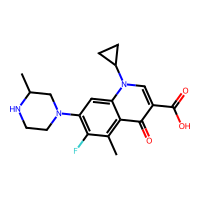

In [7]:
structural_df.head(1) # the 'Structure' column displays the molecular structures derived from 'SMILES'

# Total Chemical Space Representation 

** Only enode the molecular fingerprints of compounds for UMAP and tSNE representation. **

In [8]:
custom_markers = {
    'AB': 'o',     # circle
    'N23Ps': 's',  # square
    #'AZ': 'P',
    #"Other":"D",
    # Add more categories and marker types as needed
}
by_order = ["JJ"]  # Currently only JJ's 
type_order = ['N23Ps', 'AB']# 'AZ', 'Other'] 

In [9]:
mols = structural_df["Structure"].values[:] # take everything from col 'Structure'
# generates a 1024-bit Morgan fp (radius 3) for each Mol, converts them into NumPy arrays, returns the full set.
X = FP_For_UMAP_Generator(mols, nBits=1024)

54 mols loaded


### UMAP Representation for Fibulin-targeting compounds

Text(0.5, 1.0, 'Total Chemical Space')

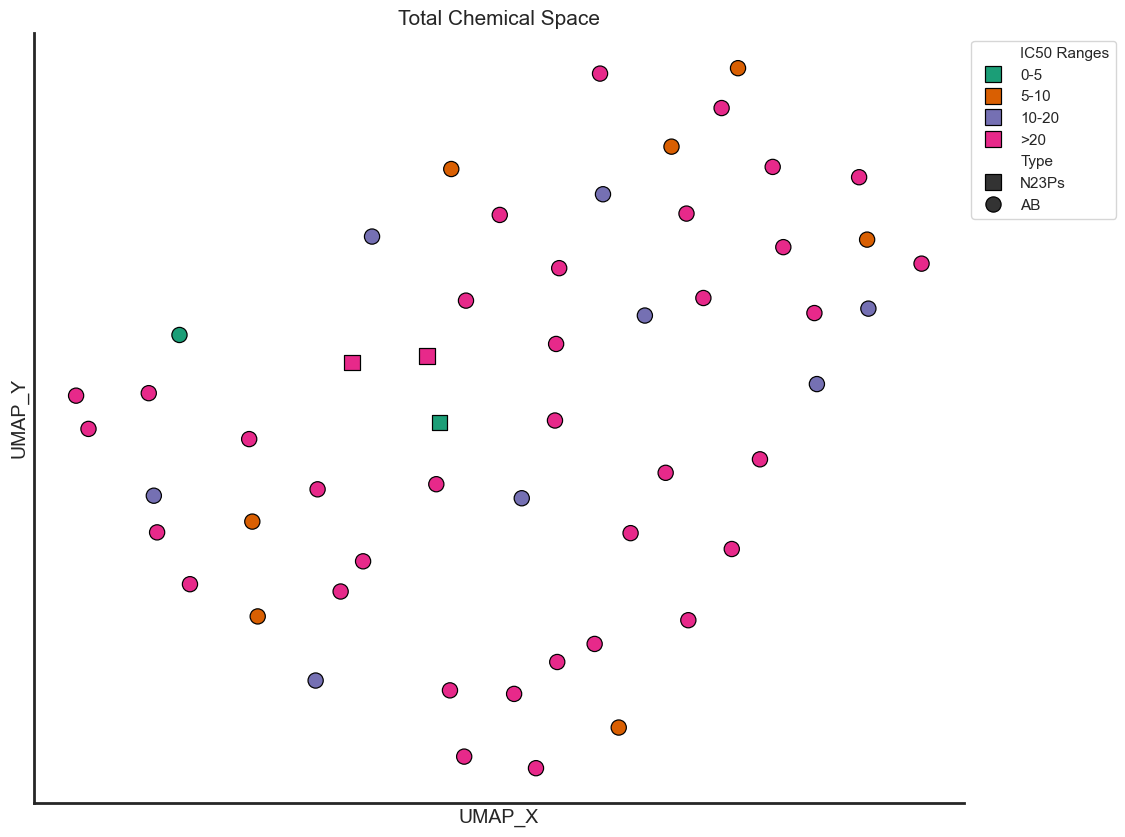

In [10]:
# X = X_molecular_fingerprint.copy()
umap_X = umap.UMAP(n_neighbors=12, #30,0.10 ORIGINAL
                   min_dist=0.75, 
                   metric=tanimoto_dist, 
                   random_state=42).fit_transform(X)

structural_df["UMAP_X"]=umap_X[:,0]
structural_df["UMAP_Y"]=umap_X[:,1]
sns.set(style='ticks')  # Set the plot style to whitegrid
plt.figure(figsize=(12, 10))
ax = sns.scatterplot(data =structural_df, x="UMAP_X", y="UMAP_Y",
                     style="Type",markers=custom_markers, hue="IC50 Ranges",
                     style_order=type_order,
                     # hue_order=by_order,
                     palette="Dark2",edgecolor='black', s=120)
sns.despine() 
ax.spines['left'].set_linewidth(2)
ax.spines['bottom'].set_linewidth(2)
plt.xticks([])
plt.yticks([])
plt.legend(loc='upper left', bbox_to_anchor=(1, 1))
plt.xlabel('UMAP_X', fontsize=14)
plt.ylabel('UMAP_Y', fontsize=14)
plt.title('Total Chemical Space', fontsize=15)
# fig_count = savefig(fig_count)

### t-SNE Representation (Preferred)

In [ ]:
# Fingerprints are 0/1 uint8 arrays of shape (n_samples,nBits)
X = X.astype(np.uint8)                            # (n, d)
n = X.shape[0]

# Vectorized Computation: Intersection A⋅B, Individual Bit Counts, Denominator, Similarity, and Distance
# Intersection: The dot product yields the number of bits set to 1 jointly for each pair of samples
intersections = X @ X.T                           # (n, n), dtype=int

# The number of 1's for each sample
ones = X.sum(axis=1, keepdims=True)               # (n, 1)

# Union = |A| + |B| - |A∩B|
denom = ones + ones.T - intersections

# Tanimoto similarity = |A∩B| / |A∪B|
with np.errstate(divide='ignore', invalid='ignore'):
    sim = np.where(denom > 0, intersections / denom, 0.0)

# Distance = 1 - similarity
dist = 1.0 - sim
np.fill_diagonal(dist, 0.0)                       # diagonal set to 0: every mol is identical to itself

# t-SNE
perp = min(20, max(5, (n - 1) // 3))              # each dot has approx. 3 neighbors, min=5, max=20
tsne = TSNE(metric='precomputed', perplexity=perp,
            random_state=42, init='random')
tsne_results = tsne.fit_transform(dist)

structural_df["tSNE_X"] = tsne_results[:, 0]
structural_df["tSNE_Y"] = tsne_results[:, 1]

Exception in thread Thread-6 (_readerthread):
Traceback (most recent call last):
  File "d:\project\conda_sar\env\lib\threading.py", line 1016, in _bootstrap_inner
    self.run()
  File "d:\project\conda_sar\env\lib\site-packages\ipykernel\ipkernel.py", line 766, in run_closure
    _threading_Thread_run(self)
  File "d:\project\conda_sar\env\lib\threading.py", line 953, in run
    self._target(*self._args, **self._kwargs)
  File "d:\project\conda_sar\env\lib\subprocess.py", line 1515, in _readerthread
    buffer.append(fh.read())
  File "d:\project\conda_sar\env\lib\codecs.py", line 322, in decode
    (result, consumed) = self._buffer_decode(data, self.errors, final)
UnicodeDecodeError: 'utf-8' codec can't decode byte 0xce in position 4: invalid continuation byte


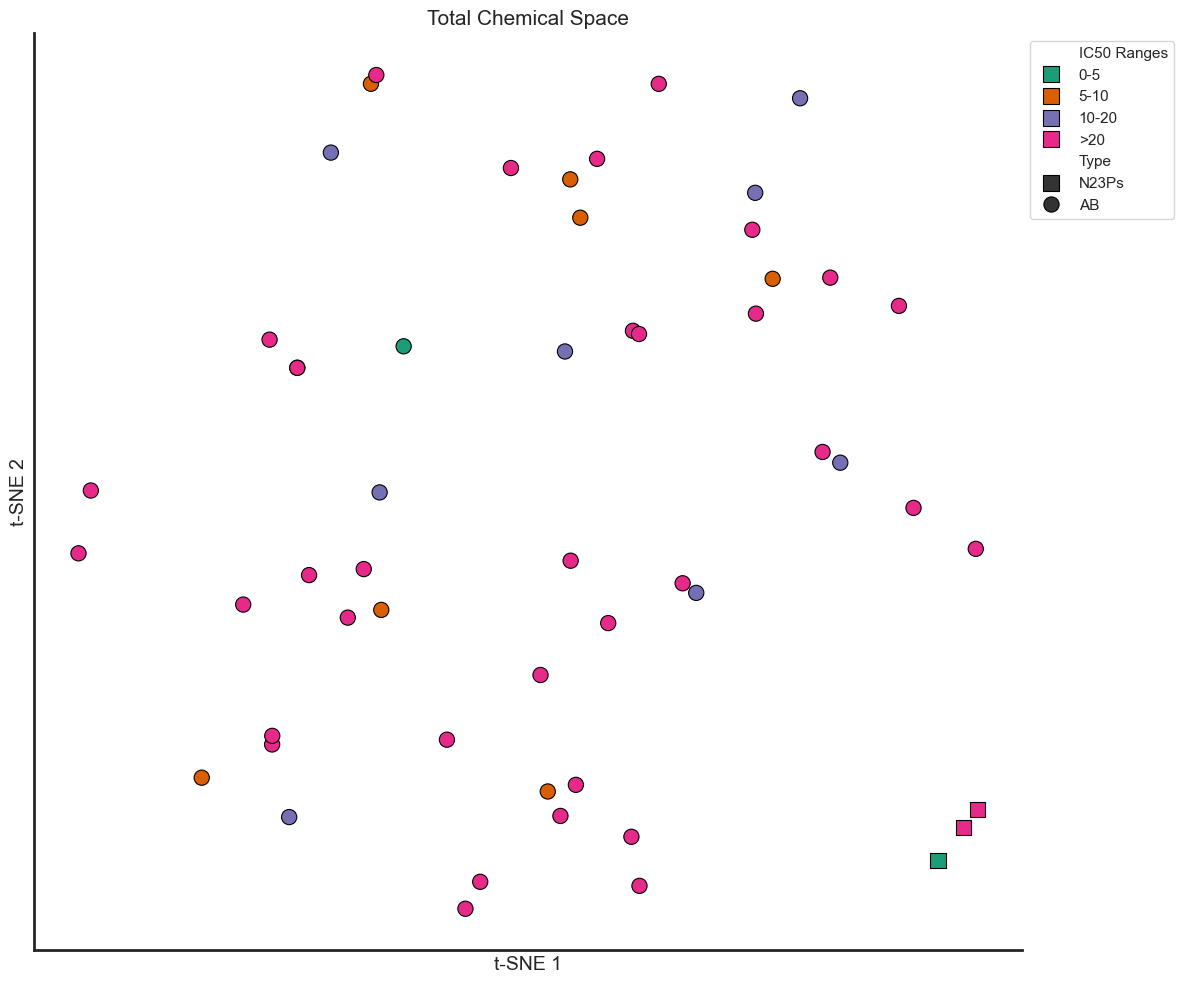

In [12]:
sns.set(style='ticks')
plt.figure(figsize=(12, 10))

ax = sns.scatterplot(
    data=structural_df, x="tSNE_X", y="tSNE_Y",
    hue="IC50 Ranges",                                                                # IC50 ranges
    style="Type", markers=custom_markers, style_order=type_order,                     # Cmp types
    #size="Any_Nuc_Toxicity", sizes={False: 250, True: 80}, size_order=[False, True],  # LD50 < 60 uM
    palette="Dark2", s=120,
    edgecolor='black', linewidth=0.8
)

sns.despine()
ax.spines['left'].set_linewidth(2)
ax.spines['bottom'].set_linewidth(2)
plt.xticks([]); plt.yticks([])
plt.xlabel('t-SNE 1', fontsize=14)
plt.ylabel('t-SNE 2', fontsize=14)
plt.title('Total Chemical Space', fontsize=15)

plt.legend(loc='upper left', bbox_to_anchor=(1, 1), frameon=True)
plt.tight_layout()
plt.show()


# ECFP

In [14]:
#Make a list of structures
mols_train = structural_df["Structure"].to_list()

#Use Sort&Slice's featuriser function to capture the diversity of the dataset
ecfp_featuriser  = create_sort_and_slice_ecfp_featuriser(mols_train, # Use morgan fingerprint instead
                                          max_radius = 2, 
                                          pharm_atom_invs = False, 
                                          bond_invs = True, 
                                          chirality = False, 
                                          sub_counts = True, 
                                          vec_dimension = 1024, 
                                          break_ties_with = lambda sub_id: sub_id, 
                                          print_train_set_info = True)


#Run all molecules through the featurizer to get ECFP encodings 
X = np.array([ecfp_featuriser(mol) for mol in mols_train])

#Calculate Pairwaise distances for plotting
distance_matrix = pairwise_distances(X, metric=tanimoto_distance)

Number of compounds in molecular training set =  54
Number of unique circular substructures with the specified parameters in molecular training set =  609


In [15]:
# Prepare list of mols
mols_train = []
for obj in structural_df["Structure"]:
    mol = ensure_mol(obj)
    if mol is None:
        # Optionally, log or collect the SMILES / object that failed
        continue
    mols_train.append(mol)

# Feature matrix
n_bits = 1024
X = np.array([ecfp4_fp(m, n_bits=n_bits) for m in mols_train])

In [16]:
# Pairwise distance matrix
distance_matrix = pairwise_distances(X, metric=tanimoto_distance)

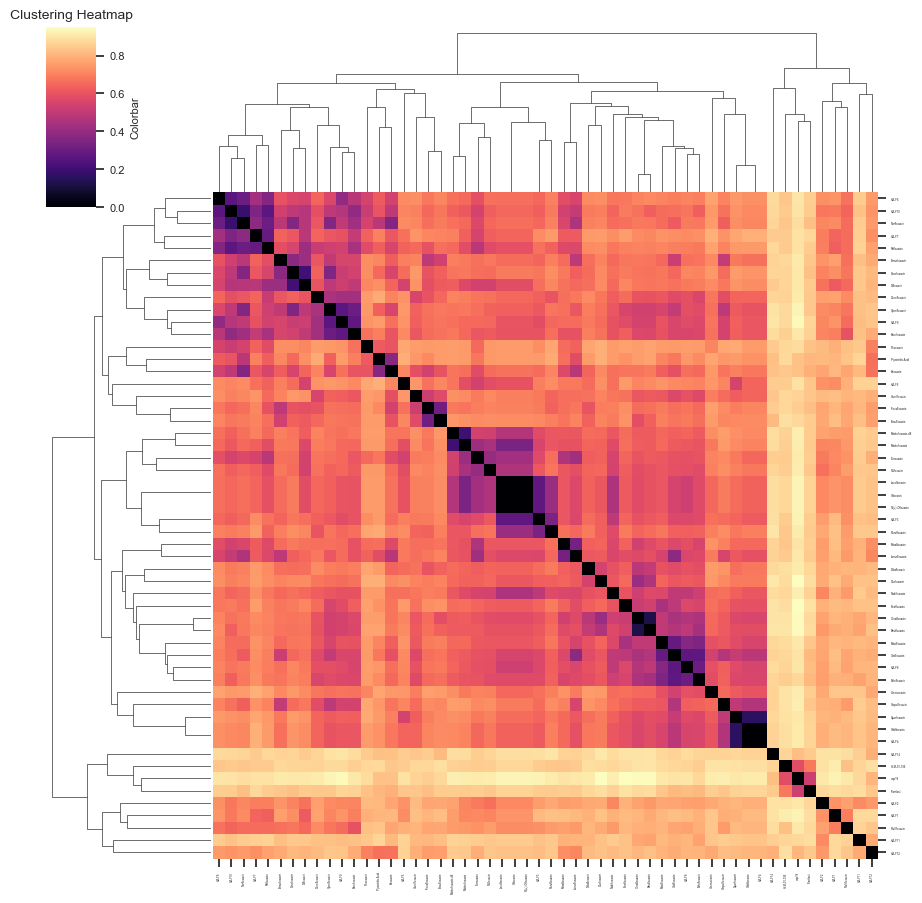

In [17]:
plot_clustering_heatmap(distance_matrix, structural_df['Compound name'].tolist())

In [18]:
num_clusters = 19
cluster_labels, linkage_matrix = perform_clustering(distance_matrix, num_clusters)

structural_df['ECFP_Cluster'] = cluster_labels

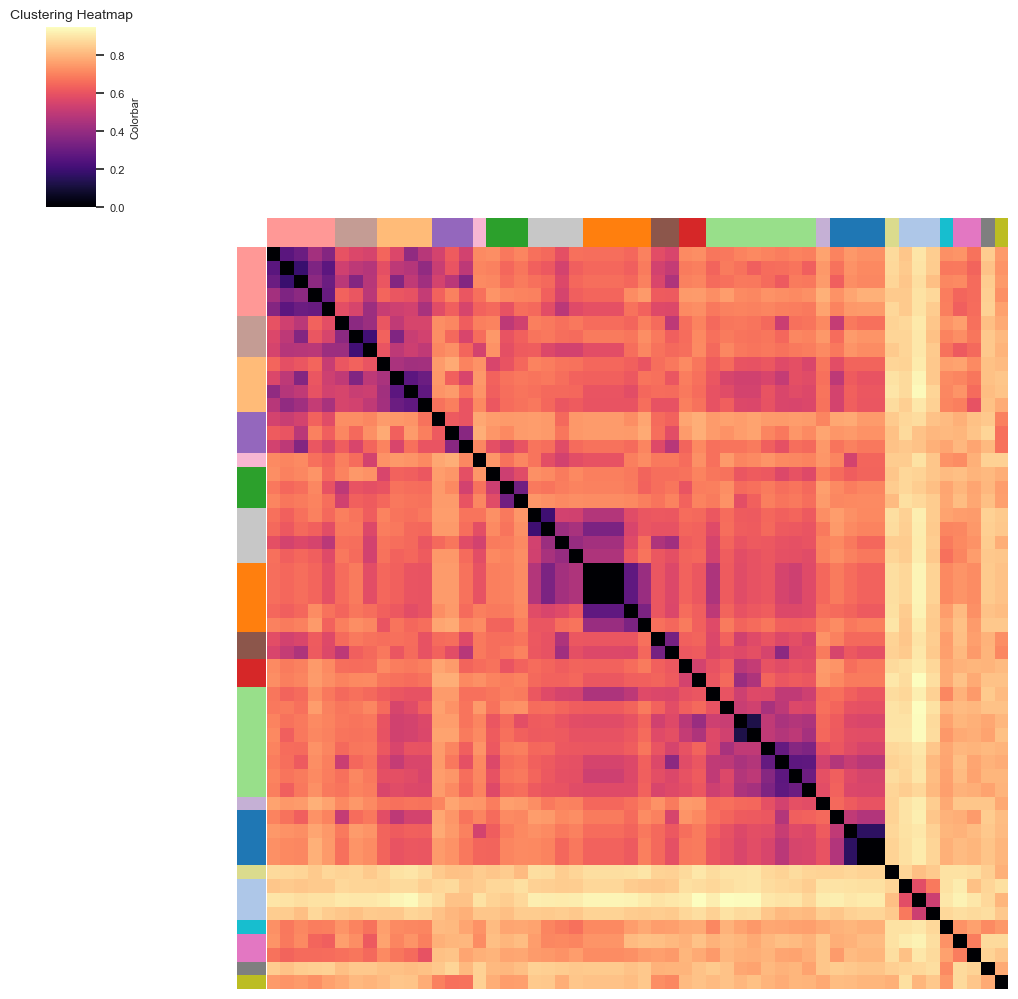

In [19]:
# Create a color palette for the clusters
unique_clusters = structural_df["ECFP_Cluster"].unique()
palette = sns.color_palette("tab20", len(unique_clusters))
cluster_colors = {cluster: palette[i] for i, cluster in enumerate(unique_clusters)}

# Map cluster labels to colors
row_colors = structural_df["ECFP_Cluster"].map(cluster_colors).to_numpy()
col_colors = row_colors  # Assuming you want the same colors for columns


# Example usage
plot_clustering_heatmap_wLabels(distance_matrix, structural_df['Compound name'].tolist(), row_colors, col_colors)

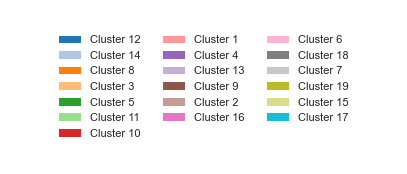

In [20]:
unique_clusters = structural_df["ECFP_Cluster"].unique()
palette = sns.color_palette("tab20", len(unique_clusters))
cluster_colors = {cluster: palette[i] for i, cluster in enumerate(unique_clusters)}
# Map cluster labels to colors
row_colors = structural_df["ECFP_Cluster"].map(cluster_colors).to_numpy()

# Example usage
plot_only_legend(cluster_colors)

Text(0, 0.5, 't-SNE Comp 2')

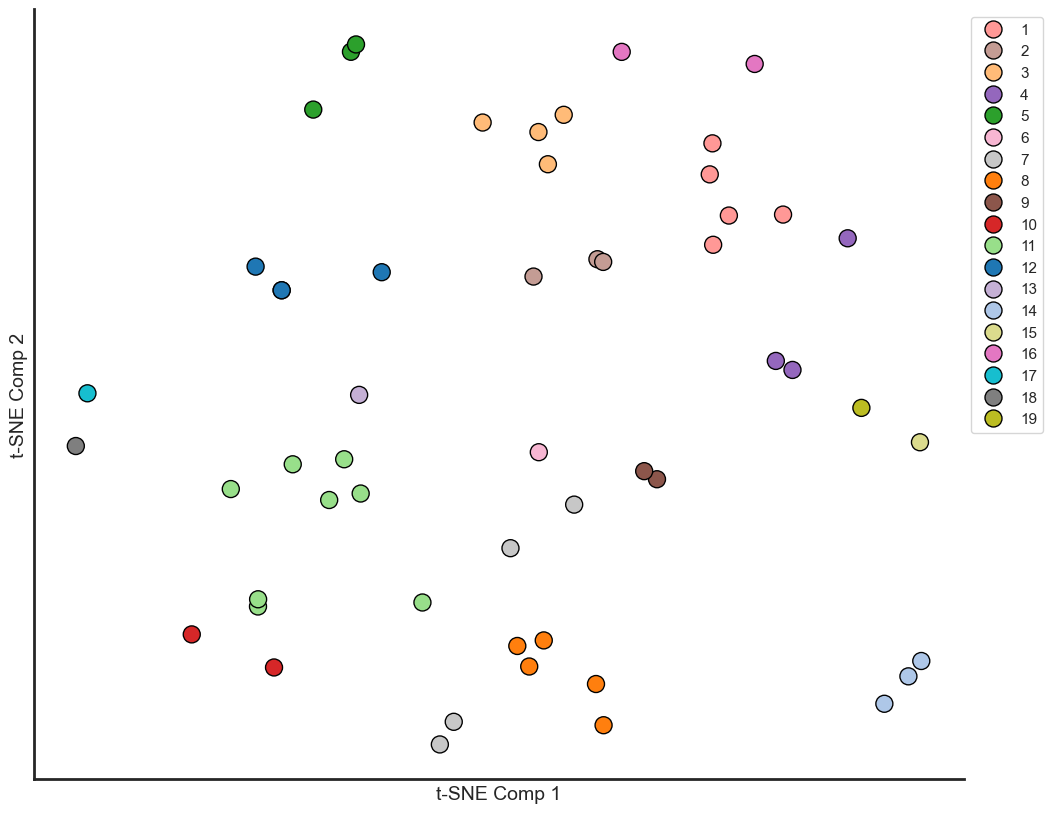

In [21]:
sns.set(style='ticks')  # Set the plot style to whitegrid
plt.figure(figsize=(12, 10))
ax = sns.scatterplot(data =structural_df, x="tSNE_X", y="tSNE_Y",
                     hue="ECFP_Cluster",#style="Toxicity_any",
                     palette=cluster_colors,edgecolor='black', s=150)
sns.despine() 
ax.spines['left'].set_linewidth(2)
ax.spines['bottom'].set_linewidth(2)
plt.xticks([])
plt.yticks([])
plt.legend(loc='upper left', bbox_to_anchor=(1, 1))
plt.xlabel('t-SNE Comp 1', fontsize=14)
plt.ylabel('t-SNE Comp 2', fontsize=14)
#plt.title('IC50 Ranges for FBLN1', fontsize=15)
# fig_count = savefig(fig_count)

In [23]:
structural_df.to_excel(r'Results/JJ/updated/Fib_SAR_df.xlsx')

- Subclustering is not necessary here 

# Subclustering

In [21]:
subcluster_df = structural_df[structural_df["ECFP_Cluster"].isin([11])]

In [31]:
#Make a list of structures
mols_train = subcluster_df["Structure"].to_list()

#Use Sort&Slice's featuriser function to capture the diversity of the dataset
ecfp_featuriser  = create_sort_and_slice_ecfp_featuriser(mols_train, 
                                          max_radius = 2, 
                                          pharm_atom_invs = False, 
                                          bond_invs = True, 
                                          chirality = False, 
                                          sub_counts = True, 
                                          vec_dimension = 1024, 
                                          break_ties_with = lambda sub_id: sub_id, 
                                          print_train_set_info = True)


#Run all molecules through the featurizer to get ECFP encodings 
X = np.array([ecfp_featuriser(mol) for mol in mols_train])

#Calculate Pairwaise distances for plotting
distance_matrix = pairwise_distances(X, metric=tanimoto_distance)

Number of compounds in molecular training set =  8
Number of unique circular substructures with the specified parameters in molecular training set =  140


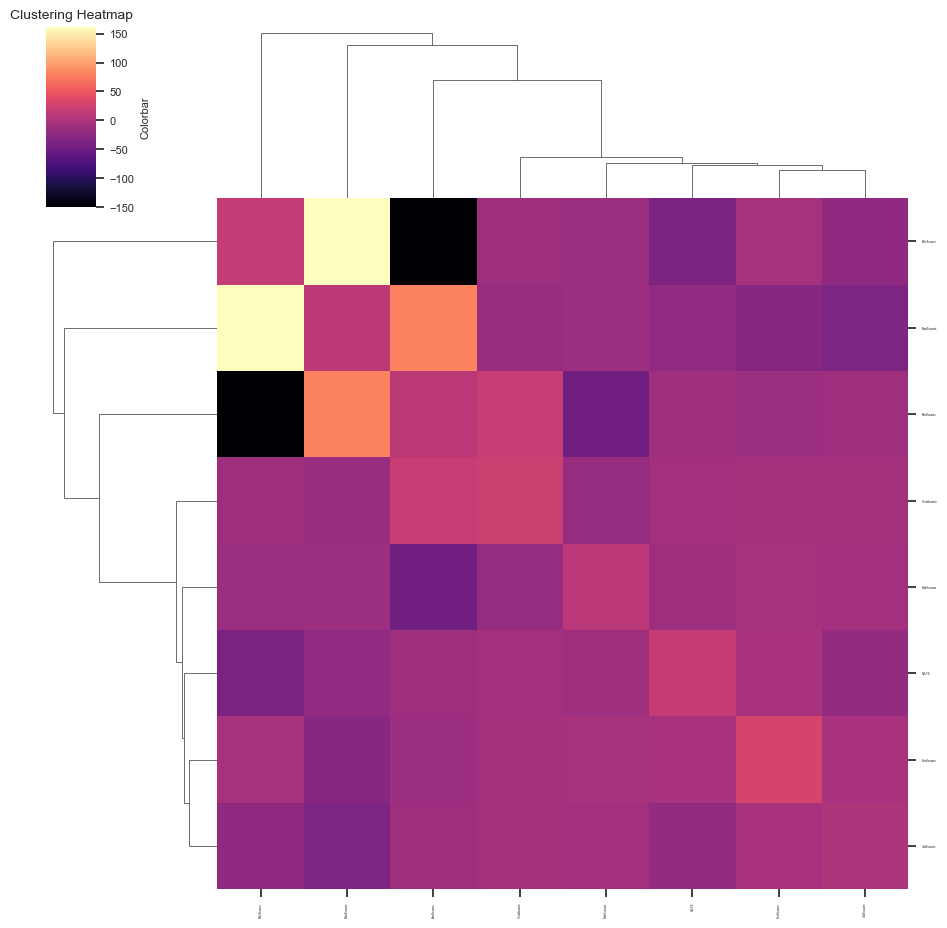

In [32]:
# Example usage
plot_clustering_heatmap(distance_matrix, subcluster_df['Compound name'].tolist())

In [24]:
num_clusters = 2 # define the number of subclusters by checking the tSNE map
# method='average': calculate the average distance of every dot pairs from two clusters; pros: good balance, resistent to noise
# criterion='maxclust': mannually define num_clusters
cluster_labels, linkage_matrix = perform_clustering(distance_matrix, num_clusters)

In [25]:
# Add cluster_labels to 'subcluster_df' under 'ECFP_Subcluster' column
subcluster_df['ECFP_Subcluster'] = cluster_labels

In [35]:
# Bring all unclustered / outlying compounds in a single cluster 
# subcluster_df.at[234, 'ECFP_Subcluster'] = 4
# subcluster_df.at[82, 'ECFP_Subcluster'] = 4
# subcluster_df.at[19, 'ECFP_Subcluster'] = 4
# subcluster_df.at[228, 'ECFP_Subcluster'] = 4
# SAR_df.at[56, 'ECFP_Cluster'] = 15

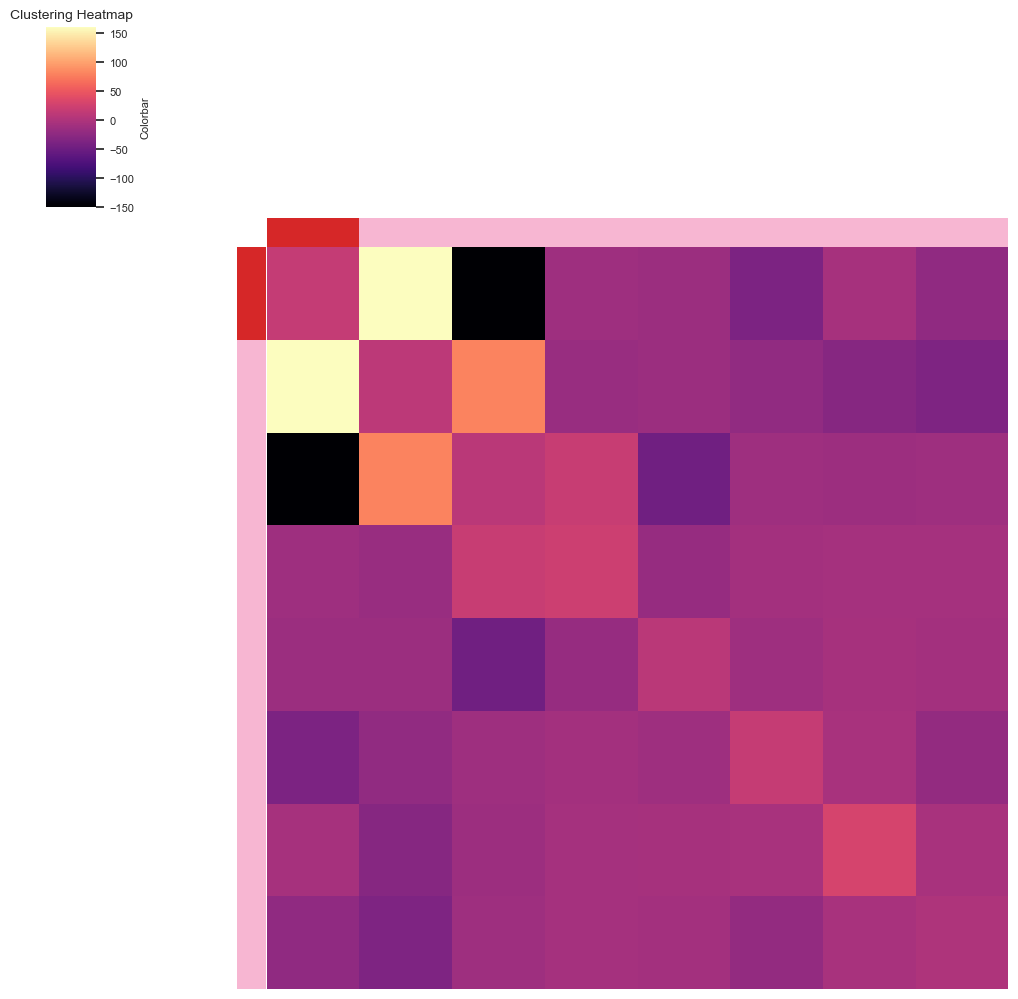

In [26]:
# Create a color palette for the clusters
unique_clusters = subcluster_df["ECFP_Subcluster"].unique()
palette = sns.color_palette("tab20_r", len(unique_clusters))
cluster_colors = {cluster: palette[i] for i, cluster in enumerate(unique_clusters)}

# Map cluster labels to colors
row_colors = subcluster_df["ECFP_Subcluster"].map(cluster_colors).to_numpy()
col_colors = row_colors  # Assuming you want the same colors for columns


# Example usage
plot_clustering_heatmap_wLabels(distance_matrix, subcluster_df['Compound name'].tolist(), row_colors, col_colors)

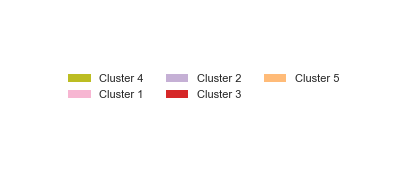

In [37]:
plot_only_legend(cluster_colors)

### Transfering Subcluster information to original clustering

In [38]:
# Prevent the indexing conflict with original clusters by adding 10 to each subcluster indexes
subcluster_df["ECFP_Subcluster"] = subcluster_df["ECFP_Subcluster"]+10
# Mask the cluster being subclustered
mask = SAR_df["ECFP_Cluster"].isin([3, 5])

SAR_df["ECFP_Cluster2"] =SAR_df["ECFP_Cluster"]
SAR_df.loc[mask,"ECFP_Cluster2"]=subcluster_df["ECFP_Subcluster"]

# Postprocessing after Subclustering

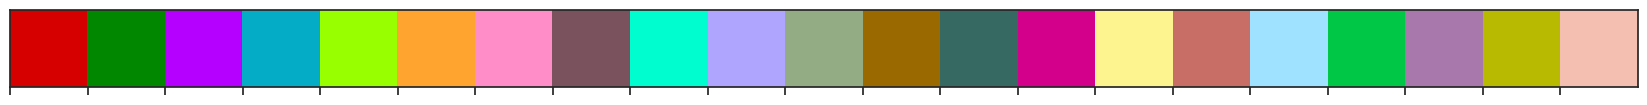

In [39]:
# Generate synthetic data
# blobs, labels = make_blobs(n_samples=1000, centers=25, center_box=(-100, 100))
# Generate a 21-color palette from colorcet's glasbey palette
custom_palette = sns.color_palette(cc.glasbey_light, n_colors=21)
sns.palplot(custom_palette)

In [40]:
unique_clusters = sorted(SAR_df['ECFP_Cluster2'].unique())
cluster_mapping = {old: new for new, old in enumerate(unique_clusters, start=1)}
SAR_df['ECFP_Cluster2'] = SAR_df['ECFP_Cluster2'].map(cluster_mapping)

In [41]:
#Make a list of structures
mols_train = SAR_df["Structure"].to_list()

#Use Sort&Slice's featuriser function to capture the diversity of the dataset
ecfp_featuriser  = create_sort_and_slice_ecfp_featuriser(mols_train, 
                                          max_radius = 2, 
                                          pharm_atom_invs = False, 
                                          bond_invs = True, 
                                          chirality = False, 
                                          sub_counts = True, 
                                          vec_dimension = 1024, 
                                          break_ties_with = lambda sub_id: sub_id, 
                                          print_train_set_info = True)


#Run all molecules through the featurizer to get ECFP encodings 
X = np.array([ecfp_featuriser(mol) for mol in mols_train])

#Calculate Pairwaise distances for plotting
distance_matrix = pairwise_distances(X, metric=tanimoto_distance)

Number of compounds in molecular training set =  41
Number of unique circular substructures with the specified parameters in molecular training set =  548


In [42]:
#Export matrix to make the correlation plot again
# np.save('Results/SAR Database/MetaSAR_DB/160724 Results/RGD/Corr_heatmap_distance_matrix_final.npy', distance_matrix)

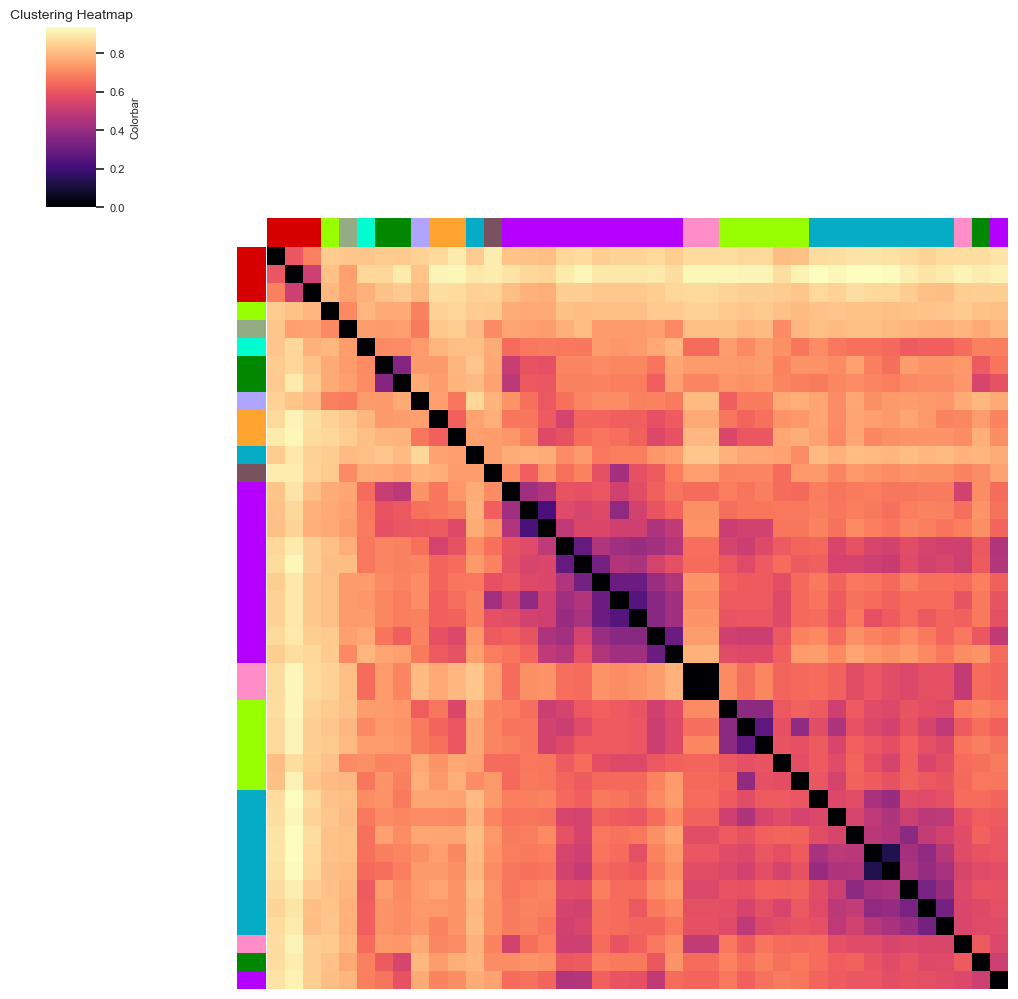

In [43]:
# Create a color palette for the clusters
unique_clusters = SAR_df["ECFP_Cluster2"].unique()
palette = sns.color_palette(custom_palette, len(unique_clusters))
cluster_colors = {cluster: palette[i] for i, cluster in enumerate(unique_clusters)}

# Map cluster labels to colors
row_colors = SAR_df["ECFP_Cluster2"].map(cluster_colors).to_numpy()
col_colors = row_colors  # Assuming you want the same colors for columns


# Example usage
plot_clustering_heatmap_wLabels(distance_matrix, SAR_df['Compound name'].tolist(), row_colors, col_colors)

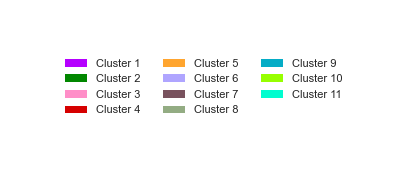

In [44]:
cluster_colors = {k: cluster_colors[k] for k in sorted(cluster_colors)}
cluster_colors
plot_only_legend(cluster_colors)

Text(0.5, 1.0, 'IC50 Ranges for FBLN1 and Tox')

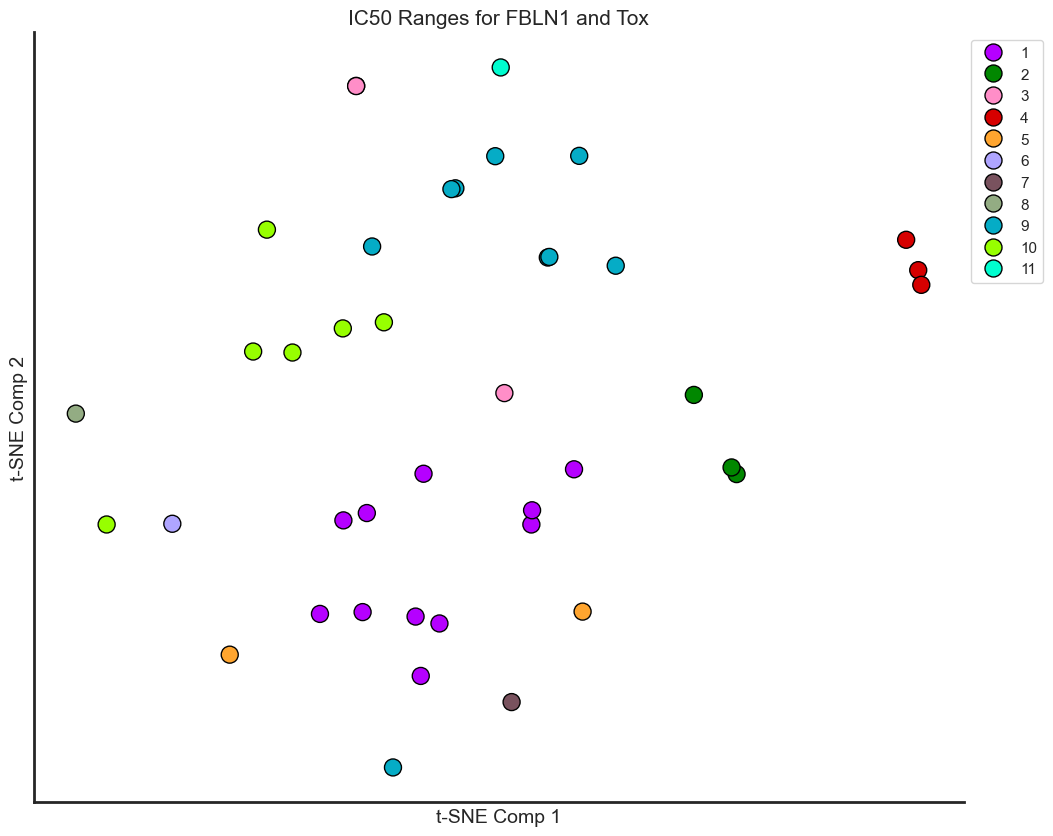

In [45]:
sns.set(style='ticks')  # Set the plot style to whitegrid
plt.figure(figsize=(12, 10))
ax = sns.scatterplot(data =SAR_df, x="tSNE_X", y="tSNE_Y",
                     hue="ECFP_Cluster2",#style="Toxicity_any",
                     palette=cluster_colors,edgecolor='black', s=150)
sns.despine() 
ax.spines['left'].set_linewidth(2)
ax.spines['bottom'].set_linewidth(2)
plt.xticks([])
plt.yticks([])
plt.legend(loc='upper left', bbox_to_anchor=(1, 1))
plt.xlabel('t-SNE Comp 1', fontsize=14)
plt.ylabel('t-SNE Comp 2', fontsize=14)
plt.title('IC50 Ranges for FBLN1 and Tox', fontsize=15)
# fig_count = savefig(fig_count)

,Compound name,SMILES,Type,Structure,IC50,Stdev,Mean_Rsq,Ns,Bestfit_IC50,Bestfit_IC50_stdev,Bestfit_IC50_CL,Any_Nuc_Toxicity,Ranges,UMAP_X,UMAP_Y,tSNE_X,tSNE_Y,ECFP_Cluster,ECFP_Cluster2
0,HLM-01-196,C(CCC)OC1=C(C=CC(=C1F)F)NC(\C=C\C1=CC2=C(OC(O2...,N23Ps,,4.673333,7.458125,0.88,9,0.63,0.02,MLT018,True,1-5,10.649795,0.490725,-1.35082,4.14185,6,4

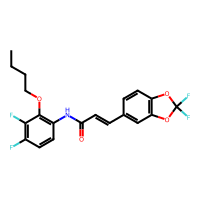

In [47]:
SAR_df.head(1)

In [48]:
SAR_df.to_excel(r'Results/JJ/updated/Fib_SAR_df.xlsx')